In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D

import cv2

In [2]:
train_dir = r'../Facial_Emotion_Recognition/train/train/'
test_dir = r'../Facial_Emotion_Recognition/test/test/'

In [3]:
def load_images(directory):
    image_paths = []
    labels = []

    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)
        if os.path.isdir(label_dir):
            for filename in os.listdir(label_dir):
                if filename.endswith('.jpg') or filename.endswith('.png'):
                    image_path = os.path.join(label_dir, filename)
                    if '\\' in image_path:
                        image_paths.append(image_path.replace('\\', '/'))
                    else:
                        image_paths.append(image_path)
                    labels.append(label)
            print(label, 'Success')
    return image_paths, labels

In [4]:
## convert to Dataframe
train = pd.DataFrame()
train['image'], train['label'] = load_images(train_dir)
## shuffle the dataset
train = train.sample(frac=1).reset_index(drop=True)
train.head()

angry Success
disgust Success
fear Success
happy Success
neutral Success
sad Success
surprise Success


,image,label
0,../Facial_Emotion_Recognition/train/train/fear...,fear
1,../Facial_Emotion_Recognition/train/train/fear...,fear
2,../Facial_Emotion_Recognition/train/train/happ...,happy
3,../Facial_Emotion_Recognition/train/train/happ...,happy
4,../Facial_Emotion_Recognition/train/train/disg...,disgust


In [5]:
## convert to Dataframe
test = pd.DataFrame()
test['image'], test['label'] = load_images(test_dir)
## shuffle the dataset
test = test.sample(frac=1).reset_index(drop=True)
test.head()

angry Success
disgust Success
fear Success
happy Success
neutral Success
sad Success
surprise Success


,image,label
0,../Facial_Emotion_Recognition/test/test/fear/P...,fear
1,../Facial_Emotion_Recognition/test/test/happy/...,happy
2,../Facial_Emotion_Recognition/test/test/happy/...,happy
3,../Facial_Emotion_Recognition/test/test/fear/P...,fear
4,../Facial_Emotion_Recognition/test/test/sad/Pr...,sad


## Exploratory Data Analysis

<AxesSubplot:xlabel='label', ylabel='count'>

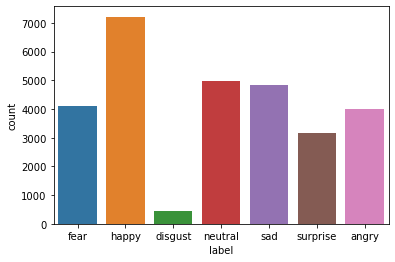

In [6]:
sns.countplot(train['label'])

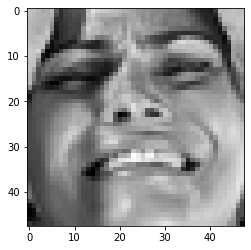

In [7]:
from PIL import Image
img = Image.open(train['image'][0])
plt.imshow(img, cmap='gray')

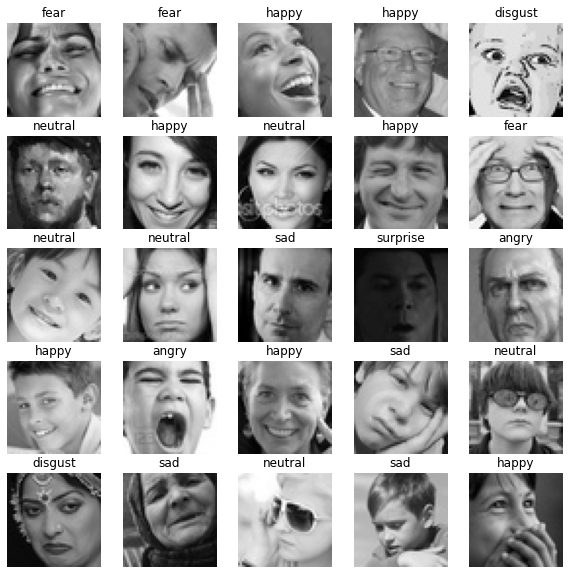

In [8]:
## to didsplay grid of images
plt.figure(figsize=(10,10))
files = train.iloc[:25]

# for tpl in files.itertuples():
#     print(tpl)

for index, row in files.iterrows():
    plt.subplot(5,5,index+1)
    img_path = row['image']
    img = cv2.imread(img_path)
    plt.imshow(img)
    plt.title(row['label'])
    plt.axis('off')

## Fuature extraction


In [9]:
def extract_features(images):
    features = []
    for image_path in tqdm(images):
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (48,48))
        img = np.array(img).reshape((48,48,1))
        features.append(img)
    features = np.array(features)
    return features

In [10]:
train_features = extract_features(train['image'])

  0%|          | 0/28709 [00:00<?, ?it/s]

In [11]:
test_features = extract_features(test['image'])

  0%|          | 0/7178 [00:00<?, ?it/s]

In [12]:
## Normalize the images
x_train = train_features/255.0
x_test = test_features/255.0

In [13]:
## convert label to interger
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['label'])
y_train = le.transform(train['label'])
y_test = le.transform(test['label'])

In [14]:
print(y_train)
print(y_test)

[2 2 3 ... 4 5 5]
[2 3 3 ... 2 5 6]


In [15]:
y_train = to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

In [16]:
y_train[0]

array([0., 0., 1., 0., 0., 0., 0.], dtype=float32)

In [17]:
# config
input_shape = (48,48,1)
output_class = 7

## Model Creation

In [18]:
model = Sequential()
#Convolutional layers
# 1st CNN layer
model.add(Conv2D(64, kernel_size=(3,3),activation='relu',input_shape = input_shape))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))
# 2nd CNN layer
model.add(Conv2D(128, kernel_size=(3,3),activation='relu',input_shape = input_shape))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))
# 3rd CNN layer
model.add(Conv2D(256, kernel_size=(3,3),activation='relu',input_shape = input_shape))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))
# 4th CNN layer
model.add(Conv2D(512, kernel_size=(3,3),activation='relu',input_shape = input_shape))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())
#Fully connected 1st layers
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))
#Fully connected 2nd layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.25))
# output layer
model.add(Dense(output_class, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

In [38]:
# train the model
history = model.fit(x=x_train, y=y_train, batch_size=128, epochs=50, validation_data=(x_test, y_test))

Epoch 1/50
225/225 [==============================] - 116s 514ms/step - loss: 1.0314 - accuracy: 0.6102 - val_loss: 1.0300 - val_accuracy: 0.6098
Epoch 2/50
225/225 [==============================] - 109s 485ms/step - loss: 1.0313 - accuracy: 0.6124 - val_loss: 1.0333 - val_accuracy: 0.6085
Epoch 3/50
225/225 [==============================] - 109s 485ms/step - loss: 1.0227 - accuracy: 0.6151 - val_loss: 1.0351 - val_accuracy: 0.6042
Epoch 4/50
225/225 [==============================] - 110s 490ms/step - loss: 1.0130 - accuracy: 0.6176 - val_loss: 1.0253 - val_accuracy: 0.6113
Epoch 5/50
225/225 [==============================] - 110s 490ms/step - loss: 1.0039 - accuracy: 0.6203 - val_loss: 1.0242 - val_accuracy: 0.6138
Epoch 6/50
225/225 [==============================] - 117s 521ms/step - loss: 1.0045 - accuracy: 0.6196 - val_loss: 1.0258 - val_accuracy: 0.6069
Epoch 7/50
225/225 [==============================] - 119s 529ms/step - loss: 0.9974 - accuracy: 0.6247 - val_loss: 1.0219 -

# Plot the Result

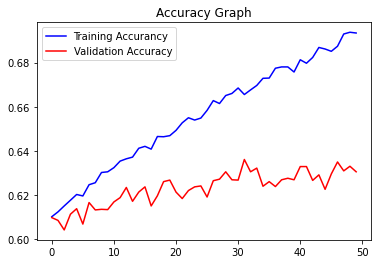

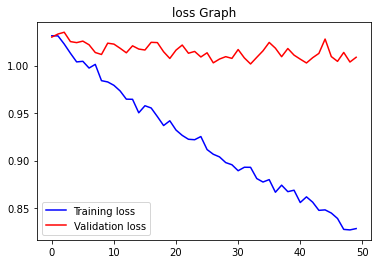

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accurancy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('loss Graph')
plt.legend()

plt.show()

## Test with Image Data

Original Output :  angry
1/1 [==============================] - 0s 24ms/step
Predicted Output:  ['angry']


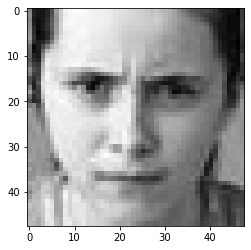

In [72]:
image_index = random.randint(0, len(test))
print('Original Output : ',test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1,48,48,1))
prediction_label = le.inverse_transform(pred.argmax().ravel())
print('Predicted Output: ',prediction_label)
plt.imshow(x_test[image_index].reshape(48,48), cmap='gray')